<a href="https://colab.research.google.com/github/Ashail33/Masters-work/blob/master/Masters_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Read the CSV file using pandas
import pandas as pd
import os
# Set the path to the 'Masters_data' folder in your Google Drive
base_path = '/content/drive/MyDrive/'
folder_name = 'Masters_data_for_viz'
folder_path = os.path.join(base_path, folder_name)

# define the file path on your Google Drive
file_path = os.path.join(folder_path, 'Full_final_dataset.csv')
data = pd.read_csv(file_path)




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd


raw_df = data

# Display the raw data
raw_df.head()
# raw_df.count()
# raw_df.nunique()



,memory_usage,memory_peak,runtime,disk_read,disk_write,cp_mean,cp_std,cp_max,cp_min,sp_mean,...,id,outliers,add_noise,n_noise,n_clusters,n_samples,n_feats,compactness_factor,distribution,file_path
0,86903185,246581764,2.426254,262144,933888,333547.654927,0.0,333547.654927,333547.654927,18.425075,...,188,500,0,NaN,3,100000,100,1.00,gaussian,/content/gdrive/MyDrive/Masters_data/dataset_1...
1,471999,82108430,2.344059,0,831488,344145.468356,0.0,344145.468356,344145.468356,19.809309,...,188,500,0,NaN,3,100000,100,1.00,gaussian,/content/gdrive/MyDrive/Masters_data/dataset_1...
2,938484,327676287,175.544398,0,50352128,333547.654927,0.0,333547.654927,333547.654927,18.425075,...,188,500,0,NaN,3,100000,100,1.00,gaussian,/content/gdrive/MyDrive/Masters_data/dataset_1...
3,76755,1176948,1.446667,0,819200,202.541622,0.0,202.541622,202.541622,9.523115,...,189,500,0,NaN,5,10000,2,0.01,gaussian,/content/gdrive/MyDrive/Masters_data/dataset_1...
4,51496,382375,0.051699,0,0,202.311498,0.0,202.311498,202.311498,9.523147,...,189,500,0,NaN,5,10000,2,0.01,gaussian,/content/gdrive/MyDrive/Masters_data/dataset_1...


In [ ]:
import pandas as pd
import numpy as np


# Define the metrics for which ranks need to be calculated
metrics = ['cp_mean', 'sp_mean', 'db_mean', 'dvi_mean', 'silhouette_mean', 'ari_mean', 'nmi_mean', 'runtime', 'memory_peak', 'disk_read', 'disk_write']

# Define whether higher values are better for each metric
higher_is_better = {'cp_mean': True, 'sp_mean': True, 'db_mean': False, 'dvi_mean': True, 'silhouette_mean': True, 'ari_mean': True, 'nmi_mean': True, 'runtime': False, 'memory_peak': False, 'disk_read': False, 'disk_write': False}

# Define a penalty factor. This could be a large number to ensure that missing runs are ranked last.
penalty_factor = 1e6  # adjust as needed

# Initialize a DataFrame to store the ranks with penalties for missing runs
ranks_with_penalty_df = pd.DataFrame()

# Group by the variables used to generate the datasets and calculate ranks for each metric within each group
grouping_variables = ['outliers', 'add_noise', 'n_noise', 'n_clusters', 'n_samples', 'n_feats', 'compactness_factor', 'distribution']
for name, group in raw_df.groupby(grouping_variables):
    for metric in metrics:
        # Assign a penalty to missing runs
        penalized_group = group.copy()
        if higher_is_better[metric]:
            penalized_group[metric].fillna(-penalty_factor, inplace=True)  # fill with a low value so that it gets a low rank
        else:
            penalized_group[metric].fillna(penalty_factor, inplace=True)  # fill with a high value so that it gets a high rank

        # Drop duplicates: Keep the first instance of each model and drop the others within each group for each metric
        penalized_group = penalized_group.drop_duplicates(subset='model', keep='first')

        # Rank the models for the current metric and group
        sorted_idx = np.argsort(penalized_group[metric], kind='stable')  # Stable sort to keep the order of the first instance
        ranks = np.empty_like(sorted_idx)
        ranks[sorted_idx] = np.arange(1, len(penalized_group) + 1)  # Assign ranks from 1 to len(group)

        ranks_with_penalty_df = ranks_with_penalty_df.append(pd.DataFrame({**{'group': str(name), 'model': penalized_group['model'].values, 'rank': ranks, 'metric': metric}, **{var: val for var, val in zip(grouping_variables, name)}}))

# Display the ranks DataFrame with penalties for missing runs
print(ranks_with_penalty_df.head())

# Initialize a DataFrame to store the aggregated ranks
aggregated_ranks_df = pd.DataFrame()

# Iterate over each unique model and metric combination to calculate the aggregated ranks
for (model, metric), group in ranks_with_penalty_df.groupby(['model', 'metric']):
    aggregated_rank = group['rank'].mean()
    aggregated_ranks_df = aggregated_ranks_df.append({'model': model, 'metric': metric, 'aggregated_rank': aggregated_rank}, ignore_index=True)

# Display the aggregated ranks DataFrame by model and metric
print(aggregated_ranks_df.head())


<ipython-input-99-1c81ee45f3f8>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ranks_with_penalty_df = ranks_with_penalty_df.append(pd.DataFrame({**{'group': str(name), 'model': penalized_group['model'].values, 'rank': ranks, 'metric': metric}, **{var: val for var, val in zip(grouping_variables, name)}}))
<ipython-input-99-1c81ee45f3f8>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ranks_with_penalty_df = ranks_with_penalty_df.append(pd.DataFrame({**{'group': str(name), 'model': penalized_group['model'].values, 'rank': ranks, 'metric': metric}, **{var: val for var, val in zip(grouping_variables, name)}}))
<ipython-input-99-1c81ee45f3f8>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ranks_with_penalty_df = ranks_w

                                          group  \
0  (0, 10, 100.0, 3, 1000, 2, 0.01, 'gaussian')   
1  (0, 10, 100.0, 3, 1000, 2, 0.01, 'gaussian')   
2  (0, 10, 100.0, 3, 1000, 2, 0.01, 'gaussian')   
3  (0, 10, 100.0, 3, 1000, 2, 0.01, 'gaussian')   
4  (0, 10, 100.0, 3, 1000, 2, 0.01, 'gaussian')   

                           model  rank   metric  outliers  add_noise  n_noise  \
0                         KMeans     1  cp_mean         0         10    100.0   
1               Parallel K-means     2  cp_mean         0         10    100.0   
2           Minibatch_clustering     3  cp_mean         0         10    100.0   
3                            S5C     5  cp_mean         0         10    100.0   
4  Weighted Consensus Clustering     4  cp_mean         0         10    100.0   

   n_clusters  n_samples  n_feats  compactness_factor distribution  
0           3       1000        2                0.01     gaussian  
1           3       1000        2                0.01     gaussian  

<ipython-input-99-1c81ee45f3f8>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aggregated_ranks_df = aggregated_ranks_df.append({'model': model, 'metric': metric, 'aggregated_rank': aggregated_rank}, ignore_index=True)
<ipython-input-99-1c81ee45f3f8>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aggregated_ranks_df = aggregated_ranks_df.append({'model': model, 'metric': metric, 'aggregated_rank': aggregated_rank}, ignore_index=True)
<ipython-input-99-1c81ee45f3f8>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aggregated_ranks_df = aggregated_ranks_df.append({'model': model, 'metric': metric, 'aggregated_rank': aggregated_rank}, ignore_index=True)
<ipython-input-99-1c81ee45f3f8>:47: FutureWarning: The frame.append

    model      metric  aggregated_rank
0  KMeans    ari_mean         3.622222
1  KMeans     cp_mean         1.235556
2  KMeans     db_mean         1.333333
3  KMeans   disk_read         1.120000
4  KMeans  disk_write         1.293333


<ipython-input-99-1c81ee45f3f8>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aggregated_ranks_df = aggregated_ranks_df.append({'model': model, 'metric': metric, 'aggregated_rank': aggregated_rank}, ignore_index=True)
<ipython-input-99-1c81ee45f3f8>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aggregated_ranks_df = aggregated_ranks_df.append({'model': model, 'metric': metric, 'aggregated_rank': aggregated_rank}, ignore_index=True)
<ipython-input-99-1c81ee45f3f8>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aggregated_ranks_df = aggregated_ranks_df.append({'model': model, 'metric': metric, 'aggregated_rank': aggregated_rank}, ignore_index=True)
<ipython-input-99-1c81ee45f3f8>:47: FutureWarning: The frame.append

In [ ]:
import numpy as np
np.max(ranks_with_penalty_df['rank'])

5

In [ ]:
from google.colab import files
# nemenyi_test_results_df

aggregated_ranks_df.to_csv('aggregated_ranks_df.csv', index=False)
files.download('aggregated_ranks_df.csv')

# friedman_test_results_df

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
aggregated_ranks_df

,model,metric,aggregated_rank
0,KMeans,ari_mean,3.622222
1,KMeans,cp_mean,1.235556
2,KMeans,db_mean,1.333333
3,KMeans,disk_read,1.120000
4,KMeans,disk_write,1.293333
5,KMeans,dvi_mean,3.377778
6,KMeans,memory_peak,2.142222
7,KMeans,nmi_mean,3.626667
8,KMeans,runtime,1.484444
9,KMeans,silhouette_mean,3.764444


In [ ]:
import scipy.stats as stats

# Initialize a DataFrame to store Friedman test results
friedman_test_results_df = pd.DataFrame()

# Define the significance level
alpha = 0.05

# List of unique models
models = raw_df['model'].unique()

# Iterate over each unique metric to perform the Friedman test
for metric, group in ranks_with_penalty_df.groupby('metric'):
    all_groups = group['group'].unique()

    # Create a new DataFrame to hold the rank data for this metric with no missing models
    complete_rank_df = pd.DataFrame()

    for g in all_groups:
        sub_group = group[group['group'] == g]
        existing_models = sub_group['model'].unique()
        missing_models = set(models) - set(existing_models)

        max_existing_rank = sub_group['rank'].max() if not sub_group.empty else 0

        # Add existing ranks
        complete_rank_df = complete_rank_df.append(sub_group)

        # Add missing models with penalty rank
        for missing_model in missing_models:
            penalty_rank = max_existing_rank + 1
            complete_rank_df = complete_rank_df.append({'group': g, 'model': missing_model, 'rank': penalty_rank, 'metric': metric}, ignore_index=True)

    # Pivot the complete rank DataFrame to get models as columns and each row as a different group (or dataset)
    rank_matrix = complete_rank_df.pivot(index='group', columns='model', values='rank')

    # Check for NaNs
    # if rank_matrix.isna().any().any():
        # print(f"NaNs found in rank_matrix for metric: {metric}")
        # print(rank_matrix)

    # Perform Friedman test
    friedman_stat, friedman_p_value = stats.friedmanchisquare(*rank_matrix.values.T)

    # Interpretation
    if friedman_p_value < alpha:
        interpretation = f'Reject the null hypothesis, significant differences exist between the models for {metric} metric at α = {alpha}.'
    else:
        interpretation = f'Fail to reject the null hypothesis, no significant differences between the models for {metric} metric at α = {alpha}.'

    # Append the Friedman test result and interpretation for the current metric to the DataFrame
    friedman_test_results_df = friedman_test_results_df.append({'metric': metric, 'friedman_stat': friedman_stat, 'friedman_p_value': friedman_p_value, 'interpretation': interpretation}, ignore_index=True)

# Display the Friedman test results DataFrame with interpretation
print(friedman_test_results_df)


Streaming output truncated to the last 5000 lines.
<ipython-input-71-cf59888f46d5>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete_rank_df = complete_rank_df.append(sub_group)
<ipython-input-71-cf59888f46d5>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete_rank_df = complete_rank_df.append(sub_group)
<ipython-input-71-cf59888f46d5>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete_rank_df = complete_rank_df.append(sub_group)
<ipython-input-71-cf59888f46d5>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete_rank_df = complete_rank_df.append(sub_group)
<ipython-input-71-cf59888f46d5>:27: FutureWarning

             metric  friedman_stat  friedman_p_value  \
0          ari_mean     118.419297      1.162097e-24   
1           cp_mean     620.246168     6.429663e-133   
2           db_mean     668.635708     2.153067e-143   
3         disk_read     789.977457     1.138302e-169   
4        disk_write     767.596934     8.010819e-165   
5          dvi_mean     109.313796      1.019365e-22   
6       memory_peak     855.111812     8.847829e-184   
7          nmi_mean     131.643823      1.733109e-27   
8           runtime     765.959423     1.812729e-164   
9   silhouette_mean     147.070334      8.638614e-31   
10          sp_mean     108.287647      1.687070e-22   

                                       interpretation  
0   Reject the null hypothesis, significant differ...  
1   Reject the null hypothesis, significant differ...  
2   Reject the null hypothesis, significant differ...  
3   Reject the null hypothesis, significant differ...  
4   Reject the null hypothesis, significant dif

<ipython-input-71-cf59888f46d5>:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  friedman_test_results_df = friedman_test_results_df.append({'metric': metric, 'friedman_stat': friedman_stat, 'friedman_p_value': friedman_p_value, 'interpretation': interpretation}, ignore_index=True)


In [ ]:
from google.colab import files
# nemenyi_test_results_df

friedman_test_results_df.to_csv('friedman_test_results_df.csv', index=False)
files.download('friedman_test_results_df.csv')

# friedman_test_results_df

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install scikit-posthocs

import scikit_posthocs as sp

# Initialize a DataFrame to store Nemenyi test results
nemenyi_test_results_df = pd.DataFrame()

# Define the significance level
alpha = 0.05

# Iterate over each unique metric to perform the Nemenyi test
for metric, group in ranks_with_penalty_df.groupby('metric'):
    # Create a DataFrame to hold the complete rank data for this metric with no missing models
    complete_rank_df = pd.DataFrame()

    # Ensure that each model has exactly one rank for each group within the metric
    for name, sub_group in group.groupby('group'):
        existing_models = sub_group['model'].tolist()
        complete_rank_df = complete_rank_df.append(sub_group[['group', 'model', 'rank']], ignore_index=True)

        # Handle missing models and append to the complete rank DataFrame
        max_rank = sub_group['rank'].max()
        for model in models:
            if model not in existing_models:
                penalty_rank = max_rank + 1
                new_row = {'group': name, 'model': model, 'rank': penalty_rank}
                complete_rank_df = complete_rank_df.append(new_row, ignore_index=True)

    # Pivot the complete rank DataFrame to get models as columns and each row as a different group (or dataset)
    rank_matrix = complete_rank_df.pivot(index='group', columns='model', values='rank')

    # Perform Nemenyi test
    nemenyi = sp.posthoc_nemenyi_friedman(rank_matrix)

    # Interpretation and Storing Results
    for i, model_i in enumerate(nemenyi.index):
        for j, model_j in enumerate(nemenyi.columns):
            if i < j:  # To avoid duplicate comparisons and self-comparisons
                p_value = nemenyi.iloc[i, j]
                if p_value < alpha:
                    interpretation = f'Significant difference between {model_i} and {model_j} for {metric} metric at α = {alpha}.'
                else:
                    interpretation = f'No significant difference between {model_i} and {model_j} for {metric} metric at α = {alpha}.'

                # Append the Nemenyi test result and interpretation for the current pair of models and metric to the DataFrame
                nemenyi_test_results_df = nemenyi_test_results_df.append({'metric': metric, 'model_i': model_i, 'model_j': model_j, 'p_value': p_value, 'interpretation': interpretation}, ignore_index=True)

# Display the Nemenyi test results DataFrame with interpretation
print(nemenyi_test_results_df)


Streaming output truncated to the last 5000 lines.
<ipython-input-73-ab2c6bd1e03d>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete_rank_df = complete_rank_df.append(sub_group[['group', 'model', 'rank']], ignore_index=True)
<ipython-input-73-ab2c6bd1e03d>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete_rank_df = complete_rank_df.append(sub_group[['group', 'model', 'rank']], ignore_index=True)
<ipython-input-73-ab2c6bd1e03d>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete_rank_df = complete_rank_df.append(sub_group[['group', 'model', 'rank']], ignore_index=True)
<ipython-input-73-ab2c6bd1e03d>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

       metric               model_i                        model_j   p_value  \
0    ari_mean                KMeans           Minibatch_clustering  0.001000   
1    ari_mean                KMeans               Parallel K-means  0.491072   
2    ari_mean                KMeans                            S5C  0.001000   
3    ari_mean                KMeans  Weighted Consensus Clustering  0.001000   
4    ari_mean  Minibatch_clustering               Parallel K-means  0.046033   
..        ...                   ...                            ...       ...   
105   sp_mean  Minibatch_clustering                            S5C  0.001000   
106   sp_mean  Minibatch_clustering  Weighted Consensus Clustering  0.119516   
107   sp_mean      Parallel K-means                            S5C  0.001000   
108   sp_mean      Parallel K-means  Weighted Consensus Clustering  0.001000   
109   sp_mean                   S5C  Weighted Consensus Clustering  0.001000   

                                       

<ipython-input-73-ab2c6bd1e03d>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete_rank_df = complete_rank_df.append(sub_group[['group', 'model', 'rank']], ignore_index=True)
<ipython-input-73-ab2c6bd1e03d>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete_rank_df = complete_rank_df.append(new_row, ignore_index=True)
<ipython-input-73-ab2c6bd1e03d>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete_rank_df = complete_rank_df.append(new_row, ignore_index=True)
<ipython-input-73-ab2c6bd1e03d>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete_rank_df = complete_rank_df.append(sub_group[['group', 'model', '

In [ ]:
from google.colab import files
# nemenyi_test_results_df

nemenyi_test_results_df.to_csv('nemenyi_test_results_df.csv', index=False)
files.download('nemenyi_test_results_df.csv')




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd

# # Load the provided data
# file_path = "path_to_your_csv_file.csv"  # Replace with the path to your CSV file
data = nemenyi_test_results_df

def format_model_name(model):
    replacements = {
        'Weighted Consensus Clustering': 'PWCC',
        'Minibatch_clustering': 'Mini Batch $k$-Means',
        'KMeans': '$k$-Means',
        'Parallel K-means': 'Parallel $k$-Means',
        '$S^{5}C$': '$S^{5}C$'
    }
    return replacements.get(model, model)

def format_metric_name(metric):
    replacements = {
        'ari_mean': 'ARI',
        'cp_mean': 'CP',
        'db_mean': 'DB',
        'disk_read': 'Disk Read',
        'disk_write': 'Disk Write',
        'dvi_mean': 'DVI',
        'memory_peak': 'RAM',
        'nmi_mean': 'NMI',
        'runtime': 'Runtime',
        'silhouette_mean': 'Silhouette',
        'sp_mean': 'SP'
    }
    return replacements.get(metric, metric)

# Creating the LaTeX longtable
latex_table = []
latex_table.append("\\begin{longtable}{|l|l|l|r|p{7cm}|}")
latex_table.append("\\caption{Nemenyi Test Results} \\label{tab:NemenyiTestResults} \\\\")
latex_table.append("\\hline")
latex_table.append("\\textbf{Metric} & \\textbf{Model I} & \\textbf{Model J} & \\textbf{$p$-value} & \\textbf{Interpretation} \\\\")
latex_table.append("\\hline")
latex_table.append("\\endfirsthead")
latex_table.append("\\multicolumn{5}{c}{{\\bfseries \\tablename\\ \\thetable{} -- continued from previous page}} \\\\")
latex_table.append("\\hline")
latex_table.append("\\textbf{Metric} & \\textbf{Model I} & \\textbf{Model J} & \\textbf{$p$-value} & \\textbf{Interpretation} \\\\")
latex_table.append("\\hline")
latex_table.append("\\endhead")
latex_table.append("\\hline")
latex_table.append("\\multicolumn{5}{|r|}{{Continued on next page}} \\\\ \\hline")
latex_table.append("\\endfoot")
latex_table.append("\\hline")
latex_table.append("\\endlastfoot")

previous_metric = None

# Iterate over each row and format it into LaTeX format
for index, row in data.iterrows():
    metric = format_metric_name(row['metric'])
    model_i = format_model_name(row['model_i'])
    model_j = format_model_name(row['model_j'])
    p_value = row['p_value']
    interpretation = row['interpretation']

    if previous_metric != metric and previous_metric is not None:
        latex_table.append("\\hline")  # Add a horizontal line between different metrics

    latex_table.append(f"{metric} & {model_i} & {model_j} & {p_value:.3f} & {interpretation} \\\\")

    previous_metric = metric

latex_table.append("\\end{longtable}")

# Write the LaTeX longtable to a text file
with open("latex_table_output.txt", "w") as file:
    file.write("\n".join(latex_table))

print("LaTeX table has been successfully written to 'latex_table_output.txt'")
files.download('latex_table_output.txt')


LaTeX table has been successfully written to 'latex_table_output.txt'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
# nemenyi_test_results_df

# nemenyi_test_results_df.to_csv('pivot_df.csv', index=False)
# files.download('pivot_df.csv')
# Convert the pivoted DataFrame to a LaTeX table format
# latex_table = pivot_df.to_latex()

# Convert the pivoted DataFrame to a LaTeX table format with formatting
latex_table = pivot_df.to_latex(escape=False, multicolumn_format='c', multicolumn=True)

# # Customize the LaTeX table for better formatting
# latex_table = latex_table.replace('\\toprule', '\\hline \\hline')
# latex_table = latex_table.replace('\\midrule', '\\hline')
# latex_table = latex_table.replace('\\bottomrule', '\\hline \\hline')
# latex_table = latex_table.replace('\\begin{tabular}{llllll}', '\\begin{tabular}{|l|l|l|l|l|l|}')
# latex_table = latex_table.replace('\\end{tabular}', '\\end{tabular}')

# Print or save the customized LaTeX table
# print(latex_table)
# Print the LaTeX table
# print(latex_table)
# Save the LaTeX table to a .tex file
with open('table.tex', 'w') as f:
    f.write(latex_table)

# Download the .tex file
from google.colab import files
files.download('table.tex')


<ipython-input-95-ef86ffee7da1>:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = pivot_df.to_latex(escape=False, multicolumn_format='c', multicolumn=True)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pivot_df

model_j                                                            Minibatch_clustering  \
metric          model_i                                                                   
ari_mean        KMeans                Significant difference between KMeans and Mini...   
                Minibatch_clustering                                                NaN   
                Parallel K-means                                                    NaN   
                S5C                                                                 NaN   
cp_mean         KMeans                Significant difference between KMeans and Mini...   
                Minibatch_clustering                                                NaN   
                Parallel K-means                                                    NaN   
                S5C                                                                 NaN   
db_mean         KMeans                Significant difference between KMeans and Mini...   
                Minibatch_clustering                                                NaN   
                Parallel K-means                                                    NaN   
                S5C                                                                 NaN   
disk_read       KMeans                Significant difference between KMeans and Mini...   
                Minibatch_clustering                                                NaN   
                Parallel K-means                                                    NaN   
                S5C                                                                 NaN   
disk_write      KMeans                Significant difference between KMeans and Mini...   
                Minibatch_clustering                                                NaN   
                Parallel K-means                                                    NaN   
                S5C                                                                 NaN   
dvi_mean        KMeans                No significant difference between KMeans and M...   
                Minibatch_clustering                                                NaN   
                Parallel K-means                                                    NaN   
                S5C                                                                 NaN   
memory_peak     KMeans                Significant difference between KMeans and Mini...   
                Minibatch_clustering                                                NaN   
                Parallel K-means                                                    NaN   
                S5C                                                                 NaN   
nmi_mean        KMeans                Significant difference between KMeans and Mini...   
                Minibatch_clustering                                                NaN   
                Parallel K-means                                                    NaN   
                S5C                                                                 NaN   
runtime         KMeans                No significant difference between KMeans and M...   
                Minibatch_clustering                                                NaN   
                Parallel K-means                                                    NaN   
                S5C                                                                 NaN   
silhouette_mean KMeans                Significant difference between KMeans and Mini...   
                Minibatch_clustering                                                NaN   
                Parallel K-means                                                    NaN   
                S5C                                                                 NaN   
sp_mean         KMeans                No significant difference between KMeans and M...   
                Minibatch_clustering                                                NaN

In [ ]:
import pandas as pd



# Pivot the DataFrame
# pivot_df = nemenyi_test_results_df.pivot(index='model_i', columns='model_j', values='interpretation')

# Pivot the DataFrame using pivot_table
pivot_df = nemenyi_test_results_df.pivot_table(index=['metric', 'model_i'], columns='model_j', values='interpretation', aggfunc='first')

# Display the pivoted DataFrame
print(pivot_df)


model_j                                                            Minibatch_clustering  \
metric          model_i                                                                   
ari_mean        KMeans                Significant difference between KMeans and Mini...   
                Minibatch_clustering                                                NaN   
                Parallel K-means                                                    NaN   
                S5C                                                                 NaN   
cp_mean         KMeans                Significant difference between KMeans and Mini...   
                Minibatch_clustering                                                NaN   
                Parallel K-means                                                    NaN   
                S5C                                                                 NaN   
db_mean         KMeans                Significant difference between KMeans and Mini...   

In [ ]:
nemenyi_test_results_df

,metric,model_i,model_j,p_value,interpretation
0,ari_mean,KMeans,Minibatch_clustering,0.001000,Significant difference between KMeans and Mini...
1,ari_mean,KMeans,Parallel K-means,0.491072,No significant difference between KMeans and P...
2,ari_mean,KMeans,S5C,0.001000,Significant difference between KMeans and S5C ...
3,ari_mean,KMeans,Weighted Consensus Clustering,0.001000,Significant difference between KMeans and Weig...
4,ari_mean,Minibatch_clustering,Parallel K-means,0.046033,Significant difference between Minibatch_clust...
...,...,...,...,...,...
105,sp_mean,Minibatch_clustering,S5C,0.001000,Significant difference between Minibatch_clust...
106,sp_mean,Minibatch_clustering,Weighted Consensus Clustering,0.119516,No significant difference between Minibatch_cl...
107,sp_mean,Parallel K-means,S5C,0.001000,Significant difference between Parallel K-mean...
108,sp_mean,Parallel K-means,Weighted Consensus Clustering,0.001000,Significant difference between Parallel K-mean...


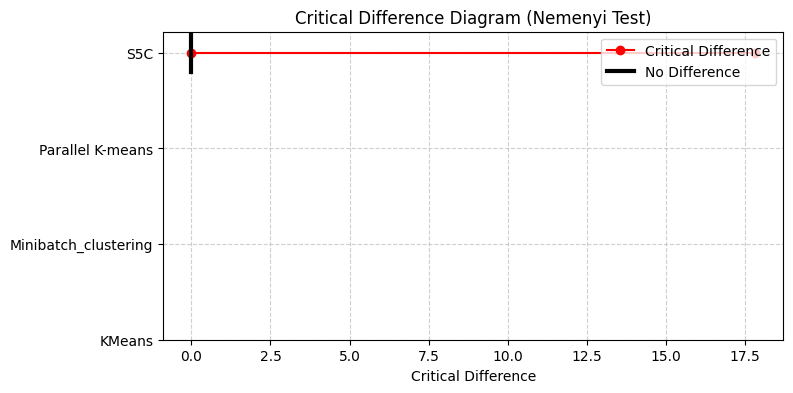

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd



# Define a function to calculate the critical difference
def calculate_critical_difference(n, k, alpha=0.05):
    q = norm.ppf(1 - alpha / (2 * k))
    return q * np.sqrt(k * (k + 1) / (6 * n))

# Define the names of the groups or models
group_names = nemenyi_test_results_df['model_i'].unique()

# Calculate the critical difference
n = len(group_names)  # Number of groups
k = nemenyi_test_results_df.shape[0] / len(group_names)  # Number of pairwise comparisons
alpha = 0.05  # Significance level

critical_difference = calculate_critical_difference(n, k, alpha)

# Create the CD diagram
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot([0, critical_difference], [n - 1, n - 1], 'ro-', label='Critical Difference')
ax.plot([0, 0], [n - 1.2, n - 0.8], 'k-', linewidth=3, label='No Difference')
ax.set_yticks(np.arange(n))
ax.set_yticklabels(group_names)
ax.set_xlabel('Critical Difference')
ax.legend(loc='upper right')

plt.title('Critical Difference Diagram (Nemenyi Test)')
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


In [ ]:
!pip install orange3==3.30
import Orange
import matplotlib.pyplot as plt
names = ['C4.5', 'C4.5+m', 'C4.5+cf', 'C4.5+m+cf']
avranks = [3.143,2.000,2.893,1.964]
cd = Orange.evaluation.compute_CD(avranks, 14,alpha='0.05', test='bonferroni-dunn') #tested on 14 datasets
print('cd=',cd)
Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=5, textspace=1.5, cdmethod=0)
plt.show();

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.6/25.6 MB 15.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 83.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.4/230.4 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.9/337.9 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.5/67.5 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 6.1 MB/s eta 0:00:00
  Created wheel for orange3: filename=Orange3-3.30.0-cp310-cp310-linux_x86_64.whl size=25840385 sha256=f213f196ceb45b5fe1f2a5f7a622e9f342abfae8

AttributeError: ignored

In [ ]:
for metric, group in ranks_with_penalty_df.groupby('metric'):
  rank_matrix = group.pivot(index='group', columns='model', values='rank')
  print(rank_matrix)

model                                             KMeans  \
group                                                      
(0, 10, 100.0, 10, 1000, 10, 0.01, 'gaussian')       4.0   
(0, 10, 100.0, 10, 1000, 10, 0.5, 'gaussian')        5.0   
(0, 10, 100.0, 10, 1000, 10, 1.0, 'gaussian')        5.0   
(0, 10, 100.0, 10, 1000, 2, 0.01, 'gaussian')        3.0   
(0, 10, 100.0, 10, 1000, 2, 0.5, 'gaussian')         3.0   
...                                                  ...   
(500, 10, 100.0, 5, 50000, 100, 0.5, 'gaussian')     3.0   
(500, 10, 100.0, 5, 50000, 100, 1.0, 'gaussian')     3.0   
(500, 10, 100.0, 5, 50000, 2, 0.01, 'gaussian')      2.0   
(500, 10, 100.0, 5, 50000, 2, 0.5, 'gaussian')       1.0   
(500, 10, 100.0, 5, 50000, 2, 1.0, 'gaussian')       3.0   

model                                             Minibatch_clustering  \
group                                                                    
(0, 10, 100.0, 10, 1000, 10, 0.01, 'gaussian')                     2.0 

In [ ]:
import scipy.stats as stats

# Initialize a DataFrame to store Friedman test results
friedman_test_results_df = pd.DataFrame()

# Define the significance level
alpha = 0.05

# Iterate over each unique metric to perform the Friedman test
for metric, group in ranks_with_penalty_df.groupby('metric'):
    # Pivot the group DataFrame to get models as columns and each row as a different group (or dataset)
    rank_matrix = group.pivot(index='group', columns='model', values='rank')

    # Perform Friedman test
    friedman_stat, friedman_p_value = stats.friedmanchisquare(*rank_matrix.values.T)

    # Interpretation
    if friedman_p_value < alpha:
        interpretation = f'Reject the null hypothesis, significant differences exist between the models for {metric} metric at α = {alpha}.'
    else:
        interpretation = f'Fail to reject the null hypothesis, no significant differences between the models for {metric} metric at α = {alpha}.'

    # Append the Friedman test result and interpretation for the current metric to the DataFrame
    friedman_test_results_df = friedman_test_results_df.append({'metric': metric, 'friedman_stat': friedman_stat, 'friedman_p_value': friedman_p_value, 'interpretation': interpretation}, ignore_index=True)

# Display the Friedman test results DataFrame with interpretation
print(friedman_test_results_df)


<ipython-input-46-9ad92465b5a0>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  friedman_test_results_df = friedman_test_results_df.append({'metric': metric, 'friedman_stat': friedman_stat, 'friedman_p_value': friedman_p_value, 'interpretation': interpretation}, ignore_index=True)
<ipython-input-46-9ad92465b5a0>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  friedman_test_results_df = friedman_test_results_df.append({'metric': metric, 'friedman_stat': friedman_stat, 'friedman_p_value': friedman_p_value, 'interpretation': interpretation}, ignore_index=True)
<ipython-input-46-9ad92465b5a0>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  friedman_test_results_df = friedman_test_results_df.append({'metric': metric, 'frie

             metric  friedman_stat  friedman_p_value  \
0          ari_mean            NaN               NaN   
1           cp_mean            NaN               NaN   
2           db_mean            NaN               NaN   
3         disk_read            NaN               NaN   
4        disk_write            NaN               NaN   
5          dvi_mean            NaN               NaN   
6       memory_peak            NaN               NaN   
7          nmi_mean            NaN               NaN   
8           runtime            NaN               NaN   
9   silhouette_mean            NaN               NaN   
10          sp_mean            NaN               NaN   

                                       interpretation  
0   Fail to reject the null hypothesis, no signifi...  
1   Fail to reject the null hypothesis, no signifi...  
2   Fail to reject the null hypothesis, no signifi...  
3   Fail to reject the null hypothesis, no signifi...  
4   Fail to reject the null hypothesis, no sign

<ipython-input-46-9ad92465b5a0>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  friedman_test_results_df = friedman_test_results_df.append({'metric': metric, 'friedman_stat': friedman_stat, 'friedman_p_value': friedman_p_value, 'interpretation': interpretation}, ignore_index=True)
<ipython-input-46-9ad92465b5a0>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  friedman_test_results_df = friedman_test_results_df.append({'metric': metric, 'friedman_stat': friedman_stat, 'friedman_p_value': friedman_p_value, 'interpretation': interpretation}, ignore_index=True)
<ipython-input-46-9ad92465b5a0>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  friedman_test_results_df = friedman_test_results_df.append({'metric': metric, 'frie

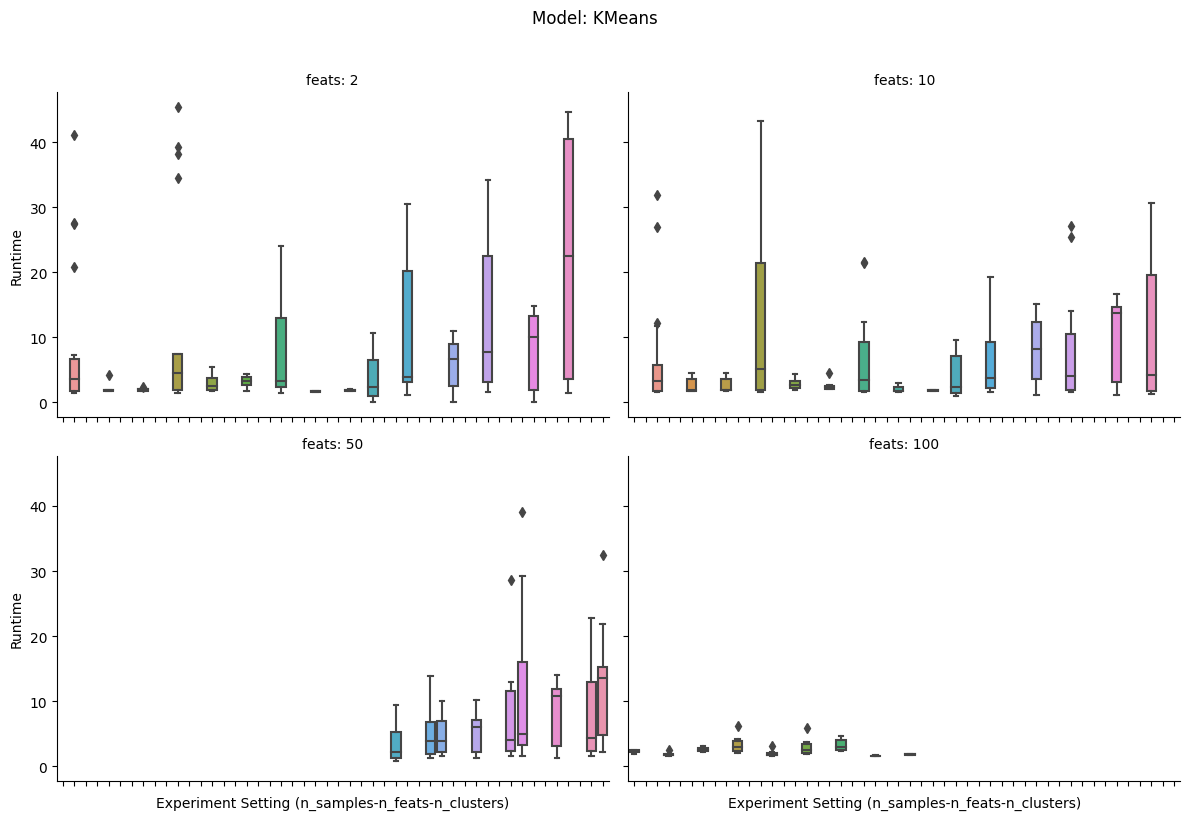

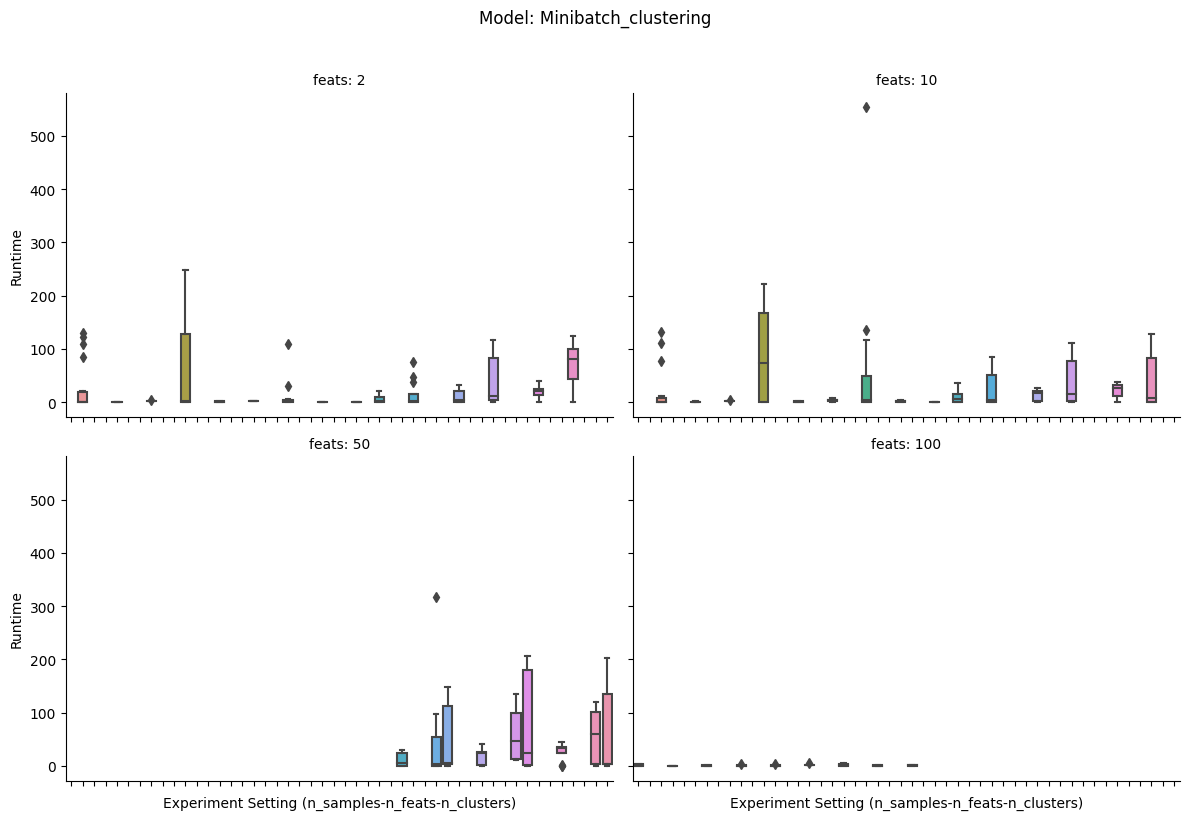

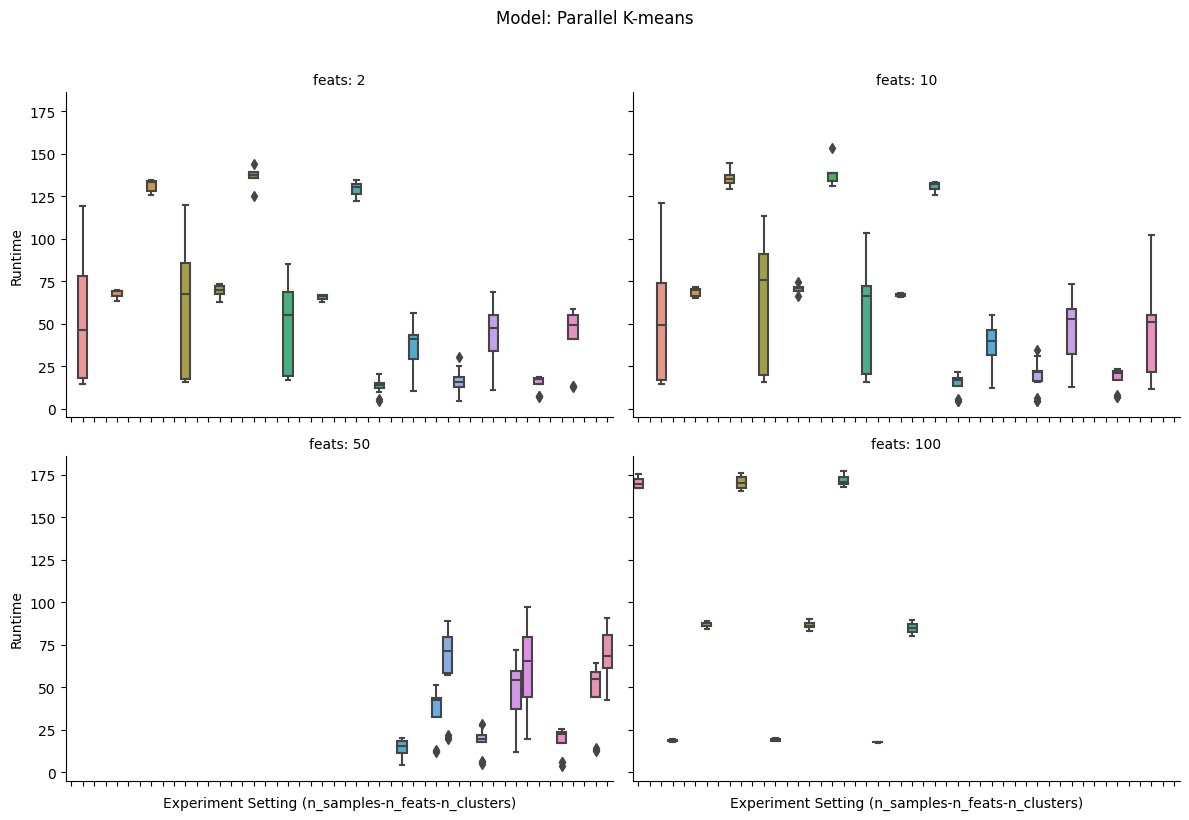

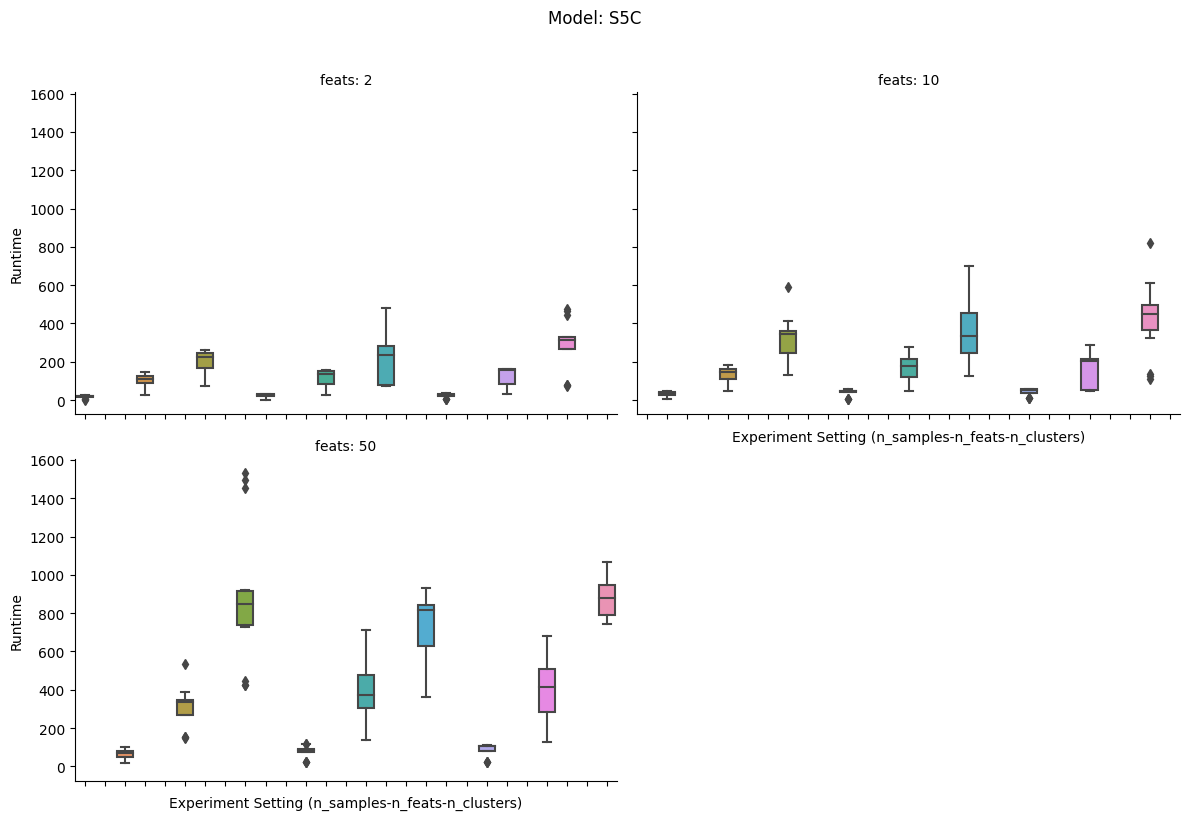

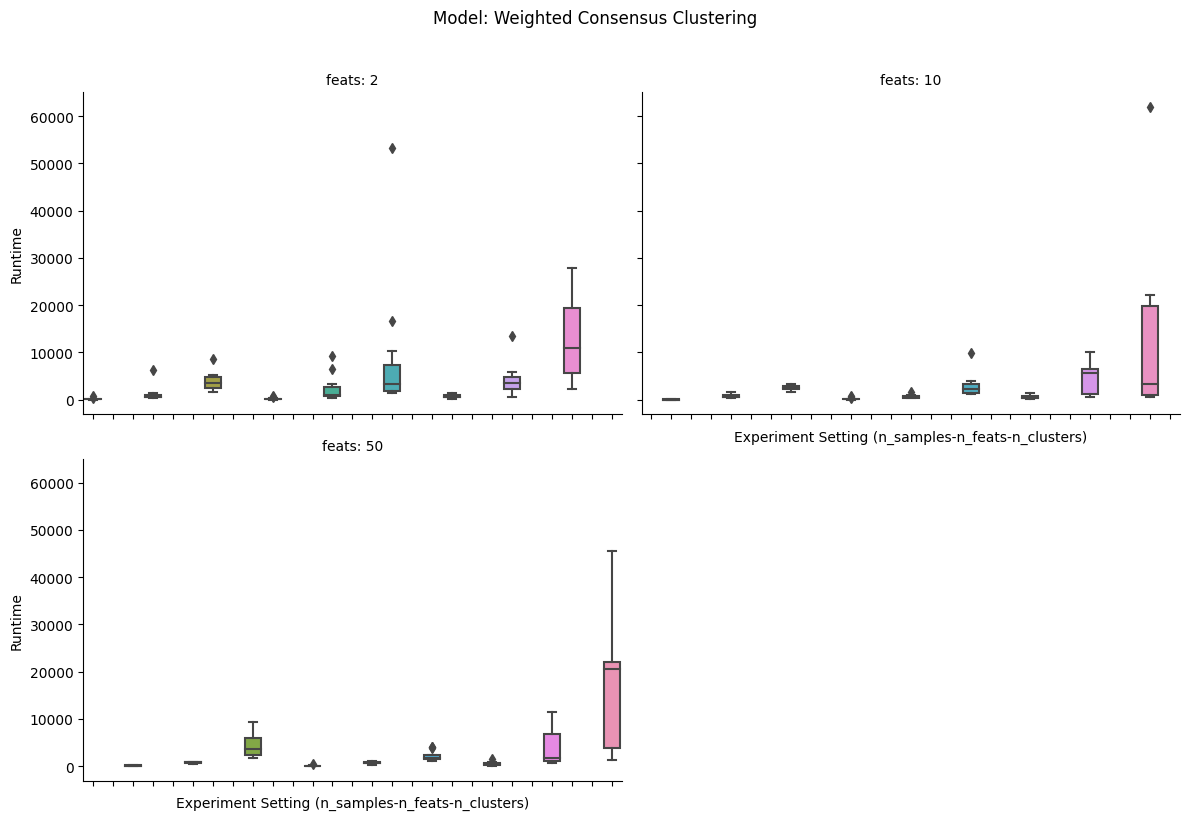

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Hypothetical DataFrame representing your experiment data
# data = {
#     'n_samples': [100, 200, 300, 100, 200, 300, 100, 200, 300, 100, 200, 300],
#     'n_feats': [5, 5, 5, 10, 10, 10, 20, 20, 20, 30, 30, 30],
#     'n_clusters': [2, 2, 2, 3, 3, 3, 4, 4, 4, 4, 4, 4],
#     'runtime': [1.2, 1.4, 1.6, 1.8, 1.3, 1.5, 1.9, 2.1, 2.4, 1.1, 0.9, 1.7],
#     'model': ['Model1', 'Model1', 'Model1', 'Model2', 'Model2', 'Model2', 'Model3', 'Model3', 'Model3', 'Model1', 'Model2', 'Model3']
# }

df = pd.DataFrame(data)

# Create a column that combines the different features for labeling
df['experiment_setting'] = df['n_samples'].astype(str) + '-' + df['n_feats'].astype(str) + '-' + df['n_clusters'].astype(str)

unique_models = df['model'].unique()

# Create separate plots for each model
for model in unique_models:
    # Filter data for the current model
    df_filtered = df[df['model'] == model]

    # Create small multiples of box plots for each model
    g = sns.catplot(
        data=df_filtered,
        x='experiment_setting',
        y='runtime',
        col='n_feats',  # This will create a small multiple for each number of clusters
        kind='box',
        col_wrap=2,  # Number of columns per row in the small multiples
        height=4, aspect=1.5  # Size and aspect ratio of individual plots
    )

    # Add titles and labels
    g.fig.suptitle(f'Model: {model}', y=1.02)
    g.set_axis_labels("Experiment Setting (n_samples-n_feats-n_clusters)", "Runtime")
    g.set_titles("feats: {col_name}")
    g.set_xticklabels(rotation=45)
    g.tight_layout()

# Show the plots
plt.show()


In [ ]:
data.columns

In [ ]:
['memory_usage', 'memory_peak', 'runtime', 'disk_read', 'disk_write',
       'memory_min', 'memory_max',
       'memory_mean', 'memory_std', 'runtime_mean', 'runtime_std',
       'runtime_max', 'runtime_min',  'model',
       'outliers', 'add_noise', 'n_noise', 'n_clusters', 'n_samples',
       'n_feats', 'compactness_factor', 'distribution']

In [ ]:
import plotly.express as px
import pandas as pd

data2=data[[
    # 'memory_usage', 'memory_peak',
            'runtime',
            # 'disk_read', 'disk_write',
      #  'memory_min', 'memory_max',
      #  'memory_mean', 'memory_std', 'runtime_mean', 'runtime_std',
      #  'runtime_max', 'runtime_min',
            'model',
      #  'outliers',
    # 'add_noise',
    # 'n_noise',
    'n_clusters', 'n_samples',
       'n_feats'
      #  , 'compactness_factor'
       , 'distribution']]
# # Sample data
# df = pd.DataFrame({
#     'A': [1, 2, 3, 4],
#     'B': [4, 3, 2, 1],
#     'C': [2, 3, 4, 1],
#     'label': ['Label1', 'Label2', 'Label1', 'Label2']
# })

# Convert 'label' to a categorical type and then to its codes (numeric representation)
data2['model'] = data2['model'].astype('category').cat.codes

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

fig = px.parallel_coordinates(data2, color='model', color_continuous_scale=colors)
# Adjusting the line thickness
# fig.update_traces(line=dict(width=2))
fig.show()






<ipython-input-4-43c0349cd176>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['model'] = data2['model'].astype('category').cat.codes


In [ ]:
import plotly.express as px
import pandas as pd

data2=data[[
    # 'memory_usage',
    'memory_peak',
            # 'runtime',
            # 'disk_read', 'disk_write',
      #  'memory_min', 'memory_max',
      #  'memory_mean', 'memory_std', 'runtime_mean', 'runtime_std',
      #  'runtime_max', 'runtime_min',
            'model',
      #  'outliers',
    # 'add_noise',
    # 'n_noise',
    'n_clusters', 'n_samples',
       'n_feats'
      #  , 'compactness_factor'
       , 'distribution']]
# # Sample data
# df = pd.DataFrame({
#     'A': [1, 2, 3, 4],
#     'B': [4, 3, 2, 1],
#     'C': [2, 3, 4, 1],
#     'label': ['Label1', 'Label2', 'Label1', 'Label2']
# })

# Convert 'label' to a categorical type and then to its codes (numeric representation)
data2['model'] = data2['model'].astype('category').cat.codes

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

fig = px.parallel_coordinates(data2, color='model', color_continuous_scale=colors)
# Adjusting the line thickness
# fig.update_traces(line=dict(width=2))
fig.show()






<ipython-input-5-0f3c39546125>:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
import plotly.express as px
import pandas as pd

data2=data[[
    # 'memory_usage',
    # 'memory_peak',
            # 'runtime',
            'disk_read',
    # 'disk_write',
      #  'memory_min', 'memory_max',
      #  'memory_mean', 'memory_std', 'runtime_mean', 'runtime_std',
      #  'runtime_max', 'runtime_min',
            'model',
      #  'outliers',
    # 'add_noise',
    # 'n_noise',
    'n_clusters', 'n_samples',
       'n_feats'
      #  , 'compactness_factor'
       , 'distribution']]
# # Sample data
# df = pd.DataFrame({
#     'A': [1, 2, 3, 4],
#     'B': [4, 3, 2, 1],
#     'C': [2, 3, 4, 1],
#     'label': ['Label1', 'Label2', 'Label1', 'Label2']
# })

# Convert 'label' to a categorical type and then to its codes (numeric representation)
data2['model'] = data2['model'].astype('category').cat.codes

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

fig = px.parallel_coordinates(data2, color='model', color_continuous_scale=colors)
# Adjusting the line thickness
# fig.update_traces(line=dict(width=2))
fig.show()






<ipython-input-6-b27af2c8c9b5>:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
import plotly.express as px
import pandas as pd

data2=data[[
    # 'memory_usage',
    # 'memory_peak',
            # 'runtime',
            # 'disk_read',
    'disk_write',
      #  'memory_min', 'memory_max',
      #  'memory_mean', 'memory_std', 'runtime_mean', 'runtime_std',
      #  'runtime_max', 'runtime_min',
            'model',
      #  'outliers',
    # 'add_noise',
    # 'n_noise',
    'n_clusters', 'n_samples',
       'n_feats'
      #  , 'compactness_factor'
       , 'distribution']]
# # Sample data
# df = pd.DataFrame({
#     'A': [1, 2, 3, 4],
#     'B': [4, 3, 2, 1],
#     'C': [2, 3, 4, 1],
#     'label': ['Label1', 'Label2', 'Label1', 'Label2']
# })

# Convert 'label' to a categorical type and then to its codes (numeric representation)
data2['model'] = data2['model'].astype('category').cat.codes

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

fig = px.parallel_coordinates(data2, color='model', color_continuous_scale=colors)
# Adjusting the line thickness
# fig.update_traces(line=dict(width=2))
fig.show()






<ipython-input-7-12ce2dfb0297>:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
import plotly.express as px
import pandas as pd

data2=data[[
    # 'memory_usage',
    # 'memory_peak',
            # 'runtime',
            # 'disk_read',
    # 'disk_write',
      #  'memory_min', 'memory_max',
      #  'memory_mean', 'memory_std', 'runtime_mean', 'runtime_std',
      #  'runtime_max', 'runtime_min',
            'model',
      #  'outliers',
    # 'add_noise',
    # 'n_noise',
    'n_clusters', 'n_samples',
       'n_feats'
      #  , 'compactness_factor'
       , 'distribution'
    ,'cp_mean'
    # , 'sp_mean'
    # , 'db_mean'
    # ,  'silhouette_mean'
    # , 'calinski_harabasz_mean'
    # ,  'ari_mean'
    # , 'nmi_mean'
    # , 'dvi_mean'

    ]]
# # Sample data
# df = pd.DataFrame({
#     'A': [1, 2, 3, 4],
#     'B': [4, 3, 2, 1],
#     'C': [2, 3, 4, 1],
#     'label': ['Label1', 'Label2', 'Label1', 'Label2']
# })

# Convert 'label' to a categorical type and then to its codes (numeric representation)
data2['model'] = data2['model'].astype('category').cat.codes

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

fig = px.parallel_coordinates(data2, color='model', color_continuous_scale=colors)
# Adjusting the line thickness
# fig.update_traces(line=dict(width=2))
fig.show()






<ipython-input-8-88c33b9e4992>:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
import plotly.express as px
import pandas as pd

data2=data[[
    # 'memory_usage',
    # 'memory_peak',
            # 'runtime',
            # 'disk_read',
    # 'disk_write',
      #  'memory_min', 'memory_max',
      #  'memory_mean', 'memory_std', 'runtime_mean', 'runtime_std',
      #  'runtime_max', 'runtime_min',
            'model',
      #  'outliers',
    # 'add_noise',
    # 'n_noise',
    'n_clusters', 'n_samples',
       'n_feats'
      #  , 'compactness_factor'
       , 'distribution'
    # ,'cp_mean'
    , 'sp_mean'
    # , 'db_mean'
    # ,  'silhouette_mean'
    # , 'calinski_harabasz_mean'
    # ,  'ari_mean'
    # , 'nmi_mean'
    # , 'dvi_mean'

    ]]
# # Sample data
# df = pd.DataFrame({
#     'A': [1, 2, 3, 4],
#     'B': [4, 3, 2, 1],
#     'C': [2, 3, 4, 1],
#     'label': ['Label1', 'Label2', 'Label1', 'Label2']
# })

# Convert 'label' to a categorical type and then to its codes (numeric representation)
data2['model'] = data2['model'].astype('category').cat.codes

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

fig = px.parallel_coordinates(data2, color='model', color_continuous_scale=colors)
# Adjusting the line thickness
# fig.update_traces(line=dict(width=2))
fig.show()






<ipython-input-9-69b75442ef95>:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
import plotly.express as px
import pandas as pd

data2=data[[
    # 'memory_usage',
    # 'memory_peak',
            # 'runtime',
            # 'disk_read',
    # 'disk_write',
      #  'memory_min', 'memory_max',
      #  'memory_mean', 'memory_std', 'runtime_mean', 'runtime_std',
      #  'runtime_max', 'runtime_min',
            'model',
      #  'outliers',
    # 'add_noise',
    # 'n_noise',
    'n_clusters', 'n_samples',
       'n_feats'
      #  , 'compactness_factor'
       , 'distribution'
    # ,'cp_mean'
    # , 'sp_mean'
    , 'db_mean'
    # ,  'silhouette_mean'
    # , 'calinski_harabasz_mean'
    # ,  'ari_mean'
    # , 'nmi_mean'
    # , 'dvi_mean'

    ]]
# # Sample data
# df = pd.DataFrame({
#     'A': [1, 2, 3, 4],
#     'B': [4, 3, 2, 1],
#     'C': [2, 3, 4, 1],
#     'label': ['Label1', 'Label2', 'Label1', 'Label2']
# })

# Convert 'label' to a categorical type and then to its codes (numeric representation)
data2['model'] = data2['model'].astype('category').cat.codes

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

fig = px.parallel_coordinates(data2, color='model', color_continuous_scale=colors)
# Adjusting the line thickness
# fig.update_traces(line=dict(width=2))
fig.show()






<ipython-input-10-1051f8e7af77>:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
import plotly.express as px
import pandas as pd

data2=data[[
    # 'memory_usage',
    # 'memory_peak',
            # 'runtime',
            # 'disk_read',
    # 'disk_write',
      #  'memory_min', 'memory_max',
      #  'memory_mean', 'memory_std', 'runtime_mean', 'runtime_std',
      #  'runtime_max', 'runtime_min',
            'model',
      #  'outliers',
    # 'add_noise',
    # 'n_noise',
    'n_clusters', 'n_samples',
       'n_feats'
      #  , 'compactness_factor'
       , 'distribution'
    # ,'cp_mean'
    # , 'sp_mean'
    # , 'db_mean'
    ,  'silhouette_mean'
    # , 'calinski_harabasz_mean'
    # ,  'ari_mean'
    # , 'nmi_mean'
    # , 'dvi_mean'

    ]]
# # Sample data
# df = pd.DataFrame({
#     'A': [1, 2, 3, 4],
#     'B': [4, 3, 2, 1],
#     'C': [2, 3, 4, 1],
#     'label': ['Label1', 'Label2', 'Label1', 'Label2']
# })

# Convert 'label' to a categorical type and then to its codes (numeric representation)
data2['model'] = data2['model'].astype('category').cat.codes

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

fig = px.parallel_coordinates(data2, color='model', color_continuous_scale=colors)
# Adjusting the line thickness
# fig.update_traces(line=dict(width=2))
fig.show()






<ipython-input-11-3b9ac355e586>:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
import plotly.express as px
import pandas as pd

data2=data[[
    # 'memory_usage',
    # 'memory_peak',
            # 'runtime',
            # 'disk_read',
    # 'disk_write',
      #  'memory_min', 'memory_max',
      #  'memory_mean', 'memory_std', 'runtime_mean', 'runtime_std',
      #  'runtime_max', 'runtime_min',
            'model',
      #  'outliers',
    # 'add_noise',
    # 'n_noise',
    'n_clusters', 'n_samples',
       'n_feats'
      #  , 'compactness_factor'
       , 'distribution'
    # ,'cp_mean'
    # , 'sp_mean'
    # , 'db_mean'
    # ,  'silhouette_mean'
    , 'calinski_harabasz_mean'
    # ,  'ari_mean'
    # , 'nmi_mean'
    # , 'dvi_mean'

    ]]
# # Sample data
# df = pd.DataFrame({
#     'A': [1, 2, 3, 4],
#     'B': [4, 3, 2, 1],
#     'C': [2, 3, 4, 1],
#     'label': ['Label1', 'Label2', 'Label1', 'Label2']
# })

# Convert 'label' to a categorical type and then to its codes (numeric representation)
data2['model'] = data2['model'].astype('category').cat.codes

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

fig = px.parallel_coordinates(data2, color='model', color_continuous_scale=colors)
# Adjusting the line thickness
# fig.update_traces(line=dict(width=2))
fig.show()






<ipython-input-12-6f43dd6042cd>:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
import plotly.express as px
import pandas as pd

data2=data[[
    # 'memory_usage',
    # 'memory_peak',
            # 'runtime',
            # 'disk_read',
    # 'disk_write',
      #  'memory_min', 'memory_max',
      #  'memory_mean', 'memory_std', 'runtime_mean', 'runtime_std',
      #  'runtime_max', 'runtime_min',
            'model',
      #  'outliers',
    # 'add_noise',
    # 'n_noise',
    'n_clusters', 'n_samples',
       'n_feats'
      #  , 'compactness_factor'
       , 'distribution'
    # ,'cp_mean'
    # , 'sp_mean'
    # , 'db_mean'
    # ,  'silhouette_mean'
    # , 'calinski_harabasz_mean'
    ,  'ari_mean'
    # , 'nmi_mean'
    # , 'dvi_mean'

    ]]
# # Sample data
# df = pd.DataFrame({
#     'A': [1, 2, 3, 4],
#     'B': [4, 3, 2, 1],
#     'C': [2, 3, 4, 1],
#     'label': ['Label1', 'Label2', 'Label1', 'Label2']
# })

# Convert 'label' to a categorical type and then to its codes (numeric representation)
data2['model'] = data2['model'].astype('category').cat.codes

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

fig = px.parallel_coordinates(data2, color='model', color_continuous_scale=colors)
# Adjusting the line thickness
# fig.update_traces(line=dict(width=2))
fig.show()






<ipython-input-13-6be2e2af5d41>:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
import plotly.express as px
import pandas as pd

data2=data[[
    # 'memory_usage',
    # 'memory_peak',
            # 'runtime',
            # 'disk_read',
    # 'disk_write',
      #  'memory_min', 'memory_max',
      #  'memory_mean', 'memory_std', 'runtime_mean', 'runtime_std',
      #  'runtime_max', 'runtime_min',
            'model',
      #  'outliers',
    # 'add_noise',
    # 'n_noise',
    'n_clusters', 'n_samples',
       'n_feats'
      #  , 'compactness_factor'
       , 'distribution'
    # ,'cp_mean'
    # , 'sp_mean'
    # , 'db_mean'
    # ,  'silhouette_mean'
    # , 'calinski_harabasz_mean'
    # ,  'ari_mean'
    , 'nmi_mean'
    # , 'dvi_mean'

    ]]
# # Sample data
# df = pd.DataFrame({
#     'A': [1, 2, 3, 4],
#     'B': [4, 3, 2, 1],
#     'C': [2, 3, 4, 1],
#     'label': ['Label1', 'Label2', 'Label1', 'Label2']
# })

# Convert 'label' to a categorical type and then to its codes (numeric representation)
data2['model'] = data2['model'].astype('category').cat.codes

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

fig = px.parallel_coordinates(data2, color='model', color_continuous_scale=colors)
# Adjusting the line thickness
# fig.update_traces(line=dict(width=2))
fig.show()






<ipython-input-14-be7ae2c69764>:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
import plotly.express as px
import pandas as pd

data2=data[[
    # 'memory_usage',
    # 'memory_peak',
            # 'runtime',
            # 'disk_read',
    # 'disk_write',
      #  'memory_min', 'memory_max',
      #  'memory_mean', 'memory_std', 'runtime_mean', 'runtime_std',
      #  'runtime_max', 'runtime_min',
            'model',
      #  'outliers',
    # 'add_noise',
    # 'n_noise',
    'n_clusters', 'n_samples',
       'n_feats'
      #  , 'compactness_factor'
       , 'distribution'
    # ,'cp_mean'
    # , 'sp_mean'
    # , 'db_mean'
    # ,  'silhouette_mean'
    # , 'calinski_harabasz_mean'
    # ,  'ari_mean'
    # , 'nmi_mean'
    , 'dvi_mean'

    ]]
# # Sample data
# df = pd.DataFrame({
#     'A': [1, 2, 3, 4],
#     'B': [4, 3, 2, 1],
#     'C': [2, 3, 4, 1],
#     'label': ['Label1', 'Label2', 'Label1', 'Label2']
# })

# Convert 'label' to a categorical type and then to its codes (numeric representation)
data2['model'] = data2['model'].astype('category').cat.codes

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

fig = px.parallel_coordinates(data2, color='model', color_continuous_scale=colors)
# Adjusting the line thickness
# fig.update_traces(line=dict(width=2))
fig.show()






<ipython-input-15-3222ad6b6cfb>:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

